In [1]:
import pandas as pd

# Load the CSV file
file_path = '/kaggle/input/vegi-price/LeaksCleanedwithDollar.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
df.head(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  960 non-null    int64  
 1   Date        960 non-null    object 
 2   Kandy       960 non-null    float64
 3   Dambulla    960 non-null    float64
 4   Buy Rate    960 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 37.6+ KB


(   Unnamed: 0        Date  Kandy  Dambulla  Buy Rate
 0           0  2020-01-01   75.0     305.0  179.4845
 1           1  2020-01-02   75.0     265.0  179.2450
 2           2  2020-01-03   75.0     225.0  179.3145
 3           3  2020-01-06   75.0     105.0  179.3748
 4           4  2020-01-07   75.0      65.0  179.3846,
 None)

In [2]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# Assume df is your DataFrame that includes 'Kandy', 'Dambulla', and 'Buy Rate'

# Create a lagged feature for 'Buy Rate' with a lag of 30 days
df['Buy Rate Lagged'] = df['Buy Rate'].shift(7)

# Drop the first 30 rows since they will have NaN values due to the shift
df = df.dropna().reset_index(drop=True)

# Normalize the data (including Kandy, Dambulla, and Buy Rate Lagged)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Kandy', 'Dambulla', 'Buy Rate Lagged']])

# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])  # Input sequence
        y.append(data[i+seq_length][:2])  # Target sequence (next step)
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 7

# Create sequences
X, y = create_sequences(scaled_data, seq_length)

# Split the data into training, validation, and test sets
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_index = int(len(X) * train_ratio)
val_index = int(len(X) * (train_ratio + val_ratio))

X_train, X_val, X_test = X[:train_index], X[train_index:val_index], X[val_index:]
y_train, y_val, y_test = y[:train_index], y[train_index:val_index], y[val_index:]

# Display the shape of the resulting arrays
print("Training Set:", X_train.shape, y_train.shape)
print("Validation Set:", X_val.shape, y_val.shape)
print("Test Set:", X_test.shape, y_test.shape)

Training Set: (662, 7, 3) (662, 2)
Validation Set: (142, 7, 3) (142, 2)
Test Set: (142, 7, 3) (142, 2)


In [3]:
# Convert 'Date' to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Check for missing values
missing_values = df.isnull().sum()

# Display the result
df.set_index('Date', inplace=True)
df = df[['Kandy', 'Dambulla', 'Buy Rate Lagged']]  # We will focus on these two columns for LSTM
missing_values, df.head()

(Unnamed: 0         0
 Date               0
 Kandy              0
 Dambulla           0
 Buy Rate           0
 Buy Rate Lagged    0
 dtype: int64,
             Kandy  Dambulla  Buy Rate Lagged
 Date                                        
 2020-01-13  310.0     320.0         179.4845
 2020-01-14  305.0     280.0         179.2450
 2020-01-16  310.0     295.0         179.3145
 2020-01-17  325.0     305.0         179.3748
 2020-01-20  295.0     290.0         179.3846)

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras import mixed_precision
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping
import shutil
import os

tuner_directory = 'my_dir/bilstm_hyperparameter_tuning'

if os.path.exists(tuner_directory):
    shutil.rmtree(tuner_directory)

# Enable mixed precision training
mixed_precision.set_global_policy('mixed_float16')

# Define a function that builds the Bi-LSTM model with hyperparameters
def build_model(hp):
    model = Sequential()
    
    # First Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(units=hp.Int('units1', min_value=16, max_value=64, step=16),
                                 return_sequences=True), input_shape=(seq_length, 3)))
    model.add(Dropout(hp.Float('dropout_rate1', 0.1, 0.5, step=0.1)))
    
    # Second Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(units=hp.Int('units2', min_value=16, max_value=64, step=16),
                                 return_sequences=True)))
    model.add(Dropout(hp.Float('dropout_rate2', 0.1, 0.5, step=0.1)))
    
    # Third Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(units=hp.Int('units3', min_value=16, max_value=64, step=16),
                                 return_sequences=False)))
    model.add(Dropout(hp.Float('dropout_rate3', 0.1, 0.5, step=0.1)))
    
    # First Dense layer
    model.add(Dense(
        units=hp.Int('dense_units1', min_value=16, max_value=64, step=16),
        activation=hp.Choice('dense_activation1', values=['relu', 'tanh', 'sigmoid', 'elu', 'selu'])
    ))
    
    # Second Dense layer
    model.add(Dense(
        units=hp.Int('dense_units2', min_value=16, max_value=64, step=16),
        activation=hp.Choice('dense_activation2', values=['relu', 'tanh', 'sigmoid', 'elu', 'selu'])
    ))

    # Output layer
    model.add(Dense(2, dtype='float32'))  # Output layer with 2 outputs

    # Compile the model
    learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2, 1e-1])  # Trying different learning rates
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
    
    return model

# Define a tuner using RandomSearch
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=5,
    directory='my_dir',
    project_name='bilstm_hyperparameter_tuning'
)

# Convert data to tf.data pipelines
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32).prefetch(tf.data.AUTOTUNE)

# Run the hyperparameter search
tuner.search(train_dataset, epochs=200, validation_data=val_dataset, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Print the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

# Optionally, retrain the best model
history = best_model.fit(train_dataset, epochs=200, validation_data=val_dataset, verbose=1)


Trial 20 Complete [00h 01m 37s]
val_loss: 0.021572912484407424

Best val_loss So Far: 0.018706804141402245
Total elapsed time: 00h 20m 42s
Best Hyperparameters: {'units1': 16, 'dropout_rate1': 0.2, 'units2': 64, 'dropout_rate2': 0.1, 'units3': 16, 'dropout_rate3': 0.2, 'dense_units1': 64, 'dense_activation1': 'relu', 'dense_units2': 16, 'dense_activation2': 'tanh', 'learning_rate': 0.001}
Epoch 1/200


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0165 - val_loss: 0.0196
Epoch 2/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0200 - val_loss: 0.0186
Epoch 3/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0177 - val_loss: 0.0263
Epoch 4/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0158 - val_loss: 0.0196
Epoch 5/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0163 - val_loss: 0.0184
Epoch 6/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0136 - val_loss: 0.0190
Epoch 7/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0121 - val_loss: 0.0175
Epoch 8/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0131 - val_loss: 0.0171
Epoch 9/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0133 - val_loss: 0.0172
Epoch 10/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0162 - val_loss: 0.0183
Epoch 11/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0123 - val_loss: 0.0194
Epoch 12/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0

In [5]:
import pickle

# Assume 'model' is your trained model
with open('model.pkl', 'wb') as file:
    pickle.dump(best_model, file)


In [6]:
predictions = best_model.predict(test_dataset)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step


In [7]:
predictions_rescaled = scaler.inverse_transform(
    np.concatenate([predictions, np.zeros((predictions.shape[0], 1))], axis=1)
)[:, :2]


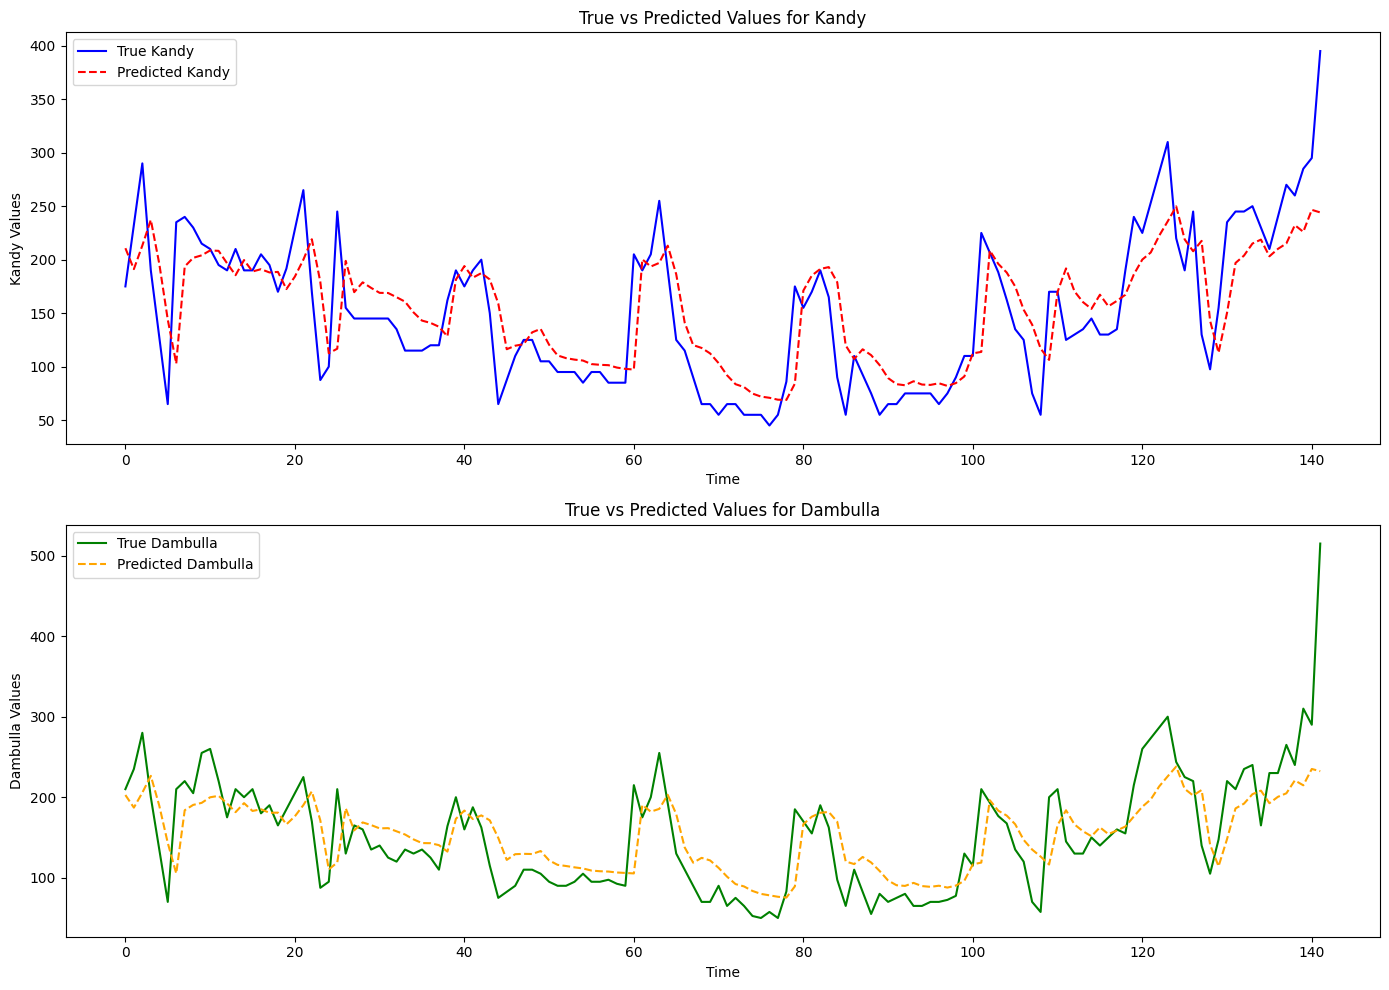

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Rescale the predictions and y_test to original scale
y_test_rescaled = scaler.inverse_transform(
    np.concatenate([y_test, np.zeros((y_test.shape[0], 1))], axis=1)
)[:, :2]


# Create two subplots for 'Kandy' and 'Dambulla'
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# Plot for Kandy
ax[0].plot(y_test_rescaled[:, 0], color='blue', label='True Kandy')
ax[0].plot(predictions_rescaled[:, 0], color='red', linestyle='--', label='Predicted Kandy')
ax[0].set_title('True vs Predicted Values for Kandy')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Kandy Values')
ax[0].legend()

# Plot for Dambulla
ax[1].plot(y_test_rescaled[:, 1], color='green', label='True Dambulla')
ax[1].plot(predictions_rescaled[:, 1], color='orange', linestyle='--', label='Predicted Dambulla')
ax[1].set_title('True vs Predicted Values for Dambulla')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Dambulla Values')
ax[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [9]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error


# Calculate the Mean Squared Error (MSE) for each target ('Kandy' and 'Dambulla')
mse_kandy = mean_squared_error(y_test_rescaled[:, 0], predictions_rescaled[:, 0])
mse_dambulla = mean_squared_error(y_test_rescaled[:, 1], predictions_rescaled[:, 1])

# Print the MSE results
print(f"MSE for Kandy: {mse_kandy}")
print(f"MSE for Dambulla: {mse_dambulla}")

# Calculate the RMSE for each target ('Kandy' and 'Dambulla')
rmse_kandy = np.sqrt(mean_squared_error(y_test_rescaled[:, 0], predictions_rescaled[:, 0]))
rmse_dambulla = np.sqrt(mean_squared_error(y_test_rescaled[:, 1], predictions_rescaled[:, 1]))

# Print the RMSE results
print(f"RMSE for Kandy: {rmse_kandy}")
print(f"RMSE for Dambulla: {rmse_dambulla}")

# Calculate the RMSLE for each target ('Kandy' and 'Dambulla')
rmsle_kandy = np.sqrt(mean_squared_log_error(y_test_rescaled[:, 0], predictions_rescaled[:, 0]))
rmsle_dambulla = np.sqrt(mean_squared_log_error(y_test_rescaled[:, 1], predictions_rescaled[:, 1]))

# Print the RMSLE results
print(f"RMSLE for Kandy: {rmsle_kandy}")
print(f"RMSLE for Dambulla: {rmsle_dambulla}")

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_kandy = mean_absolute_percentage_error(y_test_rescaled[:, 0], predictions_rescaled[:, 0])
mape_dambulla = mean_absolute_percentage_error(y_test_rescaled[:, 1], predictions_rescaled[:, 1])

# Print the MAPE results
print(f"MAPE for Kandy: {mape_kandy}%")
print(f"MAPE for Dambulla: {mape_dambulla}%")

MSE for Kandy: 1953.7237353466498
MSE for Dambulla: 2272.4386833077733
RMSE for Kandy: 44.20094722227851
RMSE for Dambulla: 47.67010261482319
RMSLE for Kandy: 0.31104407837366743
RMSLE for Dambulla: 0.3074251736725958
MAPE for Kandy: 26.680538623132044%
MAPE for Dambulla: 26.84031440030314%


In [10]:
from sklearn.metrics import mean_absolute_error

# Calculate the MAE for each target ('Kandy' and 'Dambulla')
mae_kandy = mean_absolute_error(y_test_rescaled[:, 0], predictions_rescaled[:, 0])
mae_dambulla = mean_absolute_error(y_test_rescaled[:, 1], predictions_rescaled[:, 1])

# Print the MAE results
print(f"MAE for Kandy: {mae_kandy}")
print(f"MAE for Dambulla: {mae_dambulla}")


MAE for Kandy: 33.95794349231981
MAE for Dambulla: 35.23158949857552


In [11]:
future_buy_rate_lagged = df['Buy Rate Lagged'].tail(7).values 
print(future_buy_rate_lagged)

[321.8364 322.185  322.2493 321.7707 322.2364 321.694  321.9469]


In [12]:
import numpy as np

# Number of input features; this should be 3 because we have 'Kandy', 'Dambulla', and 'Buy Rate Lagged'
n_features = 3

# `last_sequence` is the most recent sequence from the testing data
last_sequence = np.array(X_test[-1])  # Taking the last sequence from the test dataset as the starting point
last_sequence = last_sequence.reshape(1, seq_length, n_features)  # Reshape to match the input shape of the model

# Extract the next 30 "Buy Rate Lagged" values for upcoming predictions from the dataset
# Assuming `df` has the column 'Buy Rate Lagged' and is in the correct chronological order
future_buy_rate_lagged = df['Buy Rate Lagged'].tail(30).values.reshape(-1, 1)  # Last 30 days Buy Rate Lagged

# Scale the "Buy Rate Lagged" values using the same scaler used earlier
# scaled_future_buy_rate_lagged = scaler.transform(future_buy_rate_lagged)
scaler = MinMaxScaler()
scaled_future_buy_rate_lagged = scaler.fit_transform(future_buy_rate_lagged)
# Number of future predictions you want to make
n_future_steps = 30  # Predict the next 30 days

# To store future predictions
future_predictions = []

# Predict future steps iteratively using scaled "Buy Rate Lagged"
for i in range(n_future_steps):
    # Predict the next time step
    next_step = best_model.predict(last_sequence)
    
    # Store the prediction (assuming output has 2 values: 'Kandy' and 'Dambulla')
    future_predictions.append(next_step[0])  # Assuming the output is 2D: (batch_size, output_dim)

    # Prepare the next input sequence for prediction
    # Use the scaled "Buy Rate Lagged" from the future data instead of predicting it
    new_input = np.array([[next_step[0][0], next_step[0][1], scaled_future_buy_rate_lagged[i][0]]])
    
    # Update the sequence to include the latest prediction, removing the first element to maintain the sequence length
    last_sequence = np.append(last_sequence[:, 1:, :], new_input.reshape(1, 1, n_features), axis=1)

# Convert the list to a numpy array for further processing or visualization
future_predictions = np.array(future_predictions)

print("Future Predictions (Kandy, Dambulla):", future_predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

In [13]:
predictions_rescaled = scaler.inverse_transform(
    np.concatenate([future_predictions, np.zeros((future_predictions.shape[0], 1))], axis=1)
)[:, :2]


In [14]:
print(predictions_rescaled)

[[323.08685106 322.68267583]
 [322.99779636 322.62659535]
 [322.90201357 322.56071201]
 [322.85582106 322.52797576]
 [322.83971629 322.51494211]
 [322.80355181 322.48757875]
 [322.76277058 322.45769708]
 [322.70275516 322.41494144]
 [322.65806058 322.38578683]
 [322.65479438 322.3806523 ]
 [322.64065045 322.36787121]
 [322.61835613 322.35216057]
 [322.59777619 322.33872172]
 [322.59528766 322.337873  ]
 [322.59968833 322.33986978]
 [322.60328448 322.34088046]
 [322.59164152 322.33196088]
 [322.5890488  322.32905745]
 [322.61290119 322.34468008]
 [322.63695272 322.3617695 ]
 [322.64230561 322.36698623]
 [322.6380994  322.3657968 ]
 [322.63901849 322.367888  ]
 [322.64060931 322.37008933]
 [322.62405492 322.3588866 ]
 [322.60292209 322.34463688]
 [322.59888609 322.34065416]
 [322.60406153 322.34201623]
 [322.59090477 322.33074573]
 [322.59337766 322.33070589]]


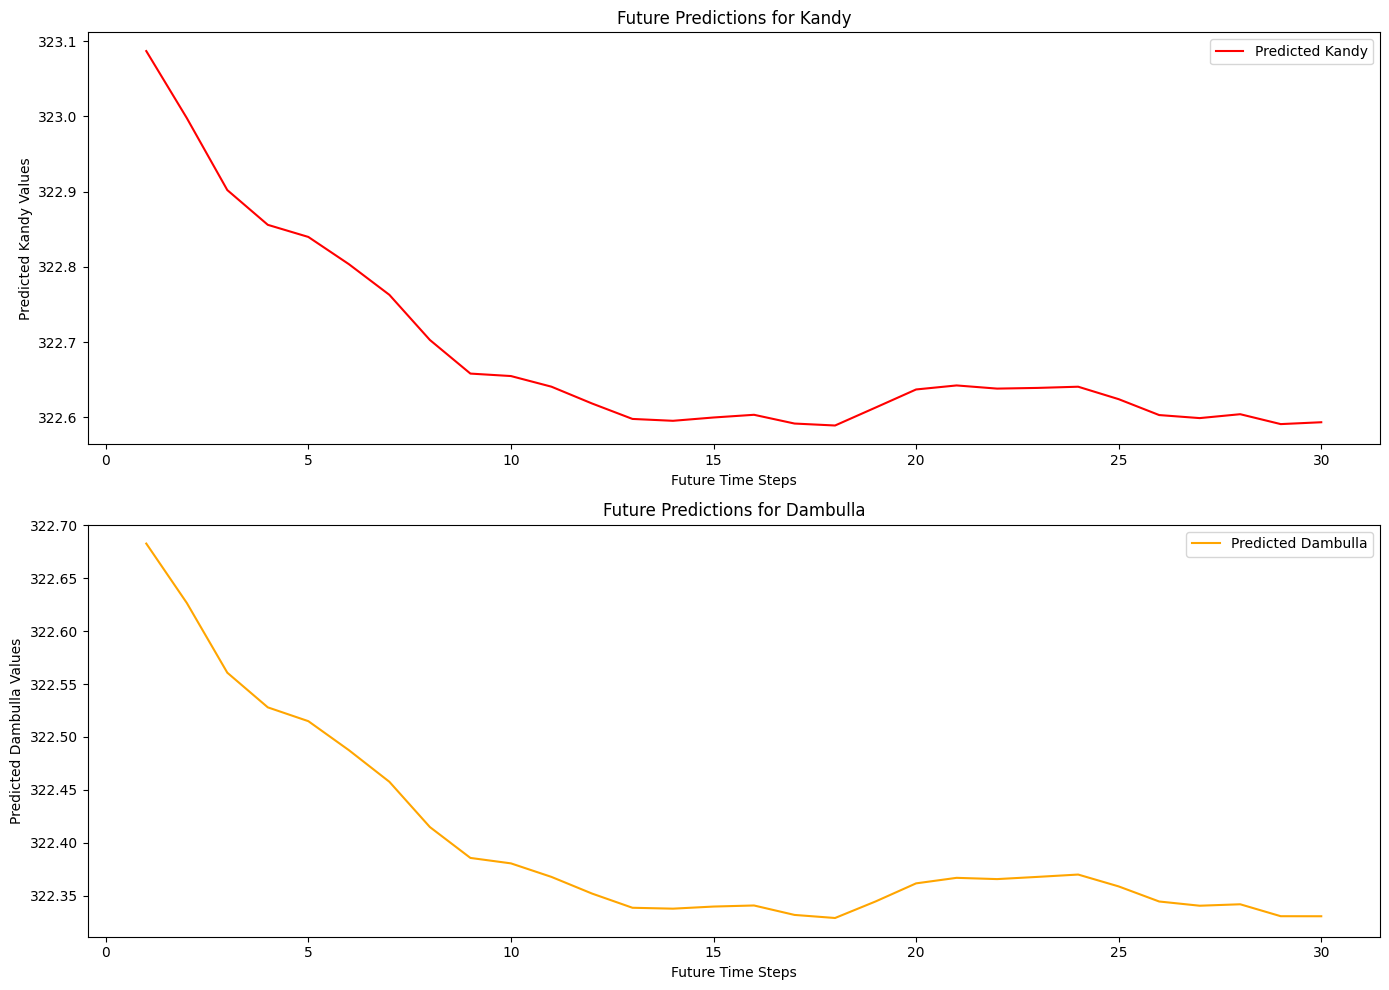

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Generate a range of future time steps based on the number of future predictions
n_future_steps = predictions_rescaled.shape[0]  # Number of future steps predicted
future_time_steps = np.arange(1, n_future_steps + 1)  # Creating a range for the x-axis

# Create two subplots for 'Kandy' and 'Dambulla'
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# Plot for Kandy
ax[0].plot(future_time_steps, predictions_rescaled[:, 0], color='red', linestyle='-', label='Predicted Kandy')
ax[0].set_title('Future Predictions for Kandy')
ax[0].set_xlabel('Future Time Steps')
ax[0].set_ylabel('Predicted Kandy Values')
ax[0].legend()

# Plot for Dambulla
ax[1].plot(future_time_steps, predictions_rescaled[:, 1], color='orange', linestyle='-',  label='Predicted Dambulla')
ax[1].set_title('Future Predictions for Dambulla')
ax[1].set_xlabel('Future Time Steps')
ax[1].set_ylabel('Predicted Dambulla Values')
ax[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()
